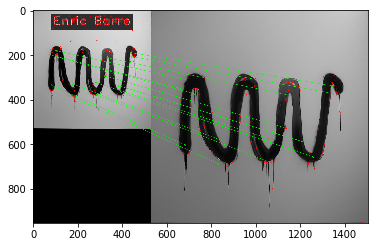

(<matplotlib.image.AxesImage at 0x7f2352b63358>, None)

In [39]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

img1_gray = cv.imread('../qs/qsd1_w2/00028.jpg', cv.IMREAD_GRAYSCALE)
img1_gray = cv.medianBlur(img1_gray, 3)

img2_gray = cv.imread('../database/bbdd_00101.jpg', cv.IMREAD_GRAYSCALE)
img2 = cv.medianBlur(img2_gray, 3)

# Initiate SIFT detector
sift = cv.xfeatures2d.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1_gray,None)
kp2, des2 = sift.detectAndCompute(img2_gray,None)

# FLANN parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)   # or pass empty dictionary
flann = cv.FlannBasedMatcher(index_params,search_params)

matches = flann.knnMatch(des1,des2,k=2)

# Need to draw only good matches, so create a mask
matchesMask = [[0,0] for i in range(len(matches))]

# ratio test as per Lowe's paper
# Iterate m and n + counter i available
for i,(m,n) in enumerate(matches):
    if m.distance < 0.4*n.distance:
        matchesMask[i]=[1,0]
        
draw_params = dict(matchColor = (0,255,0),
                   singlePointColor = (255,0,0),
                   matchesMask = matchesMask,
                   flags = cv.DrawMatchesFlags_DEFAULT)

img3 = cv.drawMatchesKnn(img1_gray,kp1,img2_gray,kp2,matches,None,**draw_params)

plt.imshow(img3,),plt.show()

In [36]:
matchesMask = [[0,0] for i in range(len(matches))]
print(matchesMask)

[[0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0],

In [40]:
import cv2 as cv
import numpy as np
from compute_mask import compute_mask
from text_removal_mask2 import find_text
from matplotlib import pyplot as plt
import glob
import os
import pickle
import ml_metrics

COLORSPACE = cv.COLOR_BGR2HSV
K = 5
size = 128
max_matches = np.zeros(K)


In [41]:
def compute_SIFT_kp_and_des(img, bg_mask, text_mask, sift, size):

    # Resize to speed up execution
    img = cv.resize(img, (size,size))

    if bg_mask is not None:
        bg_mask = cv.resize(bg_mask, (size, size))
        text_mask = cv.resize(text_mask, (size, size))
        prod = cv.bitwise_not(text_mask) * bg_mask
        prod = prod.astype(np.uint8)
        kp, des = sift.detectAndCompute(img, prod)
    else:
        kp, des = sift.detectAndCompute(img, None)

    return kp, des

In [17]:
#Show images in horizontal
from matplotlib.pyplot import figure, imshow, axis
from matplotlib.image import imread

def showImagesHorizontally(list_of_files, titles):
    fig=plt.figure(figsize=(8, 6), dpi= 80, facecolor='w', edgecolor='k')
    #fig = figure()
    number_of_files = len(list_of_files)
    j=0
    for i in range(number_of_files):
        
        a = fig.add_subplot(1,number_of_files,i+1)
        image = list_of_files[i]
        imshow(image,cmap='Greys_r')
        ax1 = axis('off')
        a.set_title(titles[j])
        a.set_xlabel(np.shape(image))
        j = j+1

In [42]:
descriptors_db = []
keypoints_db = []
final_ranking = []

# Create SIFT object
sift = cv.xfeatures2d.SIFT_create()

# FLANN parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)   # or pass empty dictionary
flann = cv.FlannBasedMatcher(index_params,search_params)

i = 0
for f in sorted(glob.glob('../database/*.jpg')):
        # Read image
        img = cv.imread(f, cv.IMREAD_COLOR)
        img = cv.medianBlur(img, 3)
        img_gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
        kps, desc = compute_SIFT_kp_and_des(img_gray, None, None, sift, size)
        descriptors_db.append(desc)
        keypoints_db.append(kps)
        i+=1
        #print(np.shape(desc))
print("DDBB descriptors computed!")

DDBB descriptors computed!


Query: 0
Most similar image: 134
Number of matches: 39.0
Query: 1
Most similar image: 23
Number of matches: 26.0
Query: 2
Most similar image: 139
Number of matches: 97.0
Query: 3
Most similar image: 143
Number of matches: 26.0
Query: 4
Most similar image: 125
Number of matches: 8.0
Query: 5
Most similar image: 10
Number of matches: 4.0
Query: 6
Most similar image: 131
Number of matches: 37.0
Query: 7
Most similar image: 105
Number of matches: 59.0
Query: 8
Most similar image: 64
Number of matches: 13.0
Query: 9
Most similar image: 106
Number of matches: 11.0
Query: 10
Most similar image: 193
Number of matches: 48.0
Query: 11
Most similar image: 68
Number of matches: 16.0
Query: 12
Most similar image: 173
Number of matches: 11.0
Query: 13
Most similar image: 115
Number of matches: 62.0
Query: 14
Most similar image: 252
Number of matches: 8.0
Query: 15
Most similar image: 216
Number of matches: 30.0
Query: 16
Most similar image: 252
Number of matches: 6.0
Query: 17
Most similar image: 16

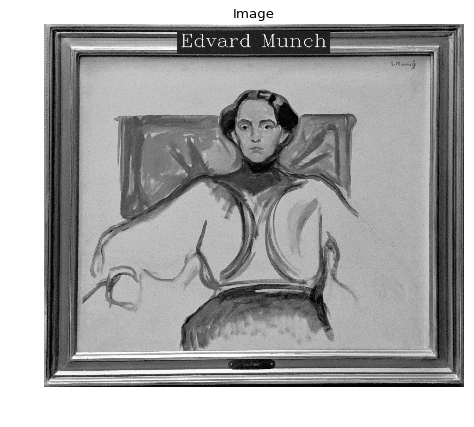

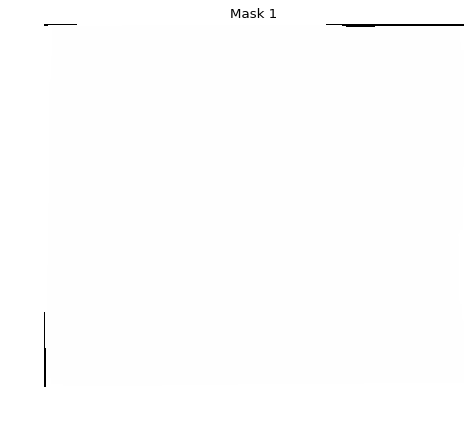

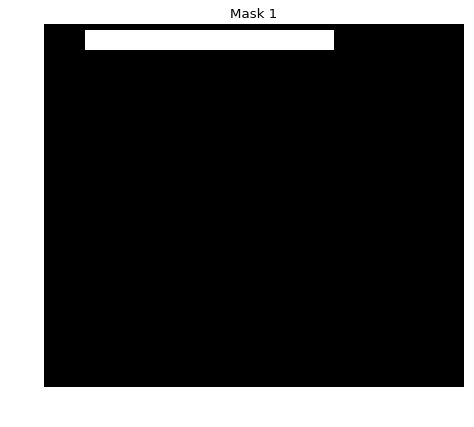

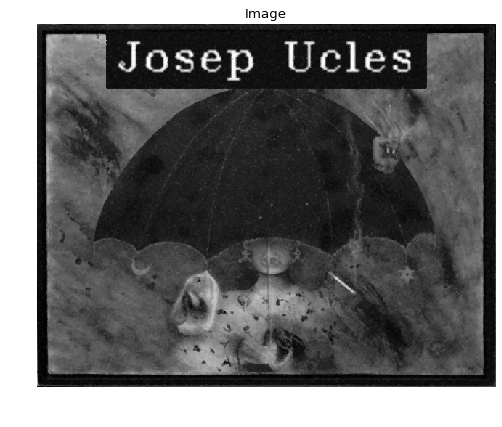

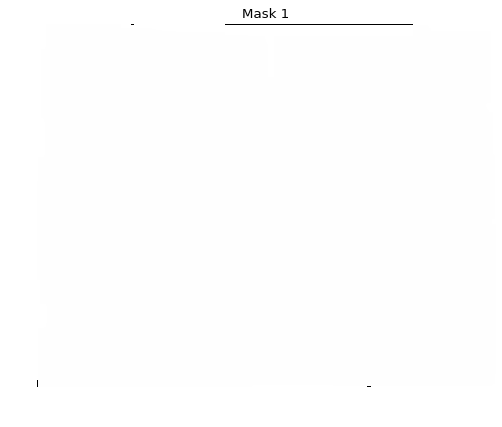

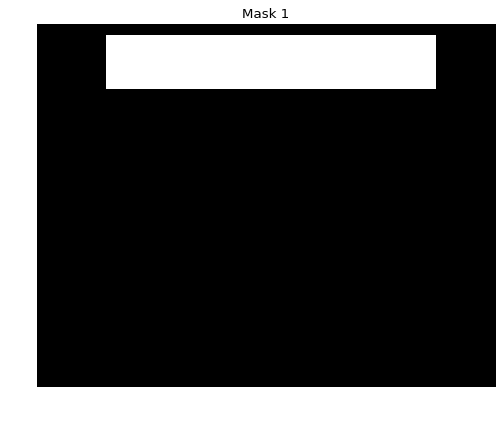

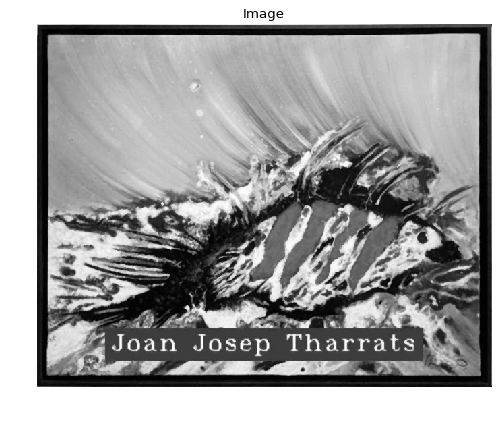

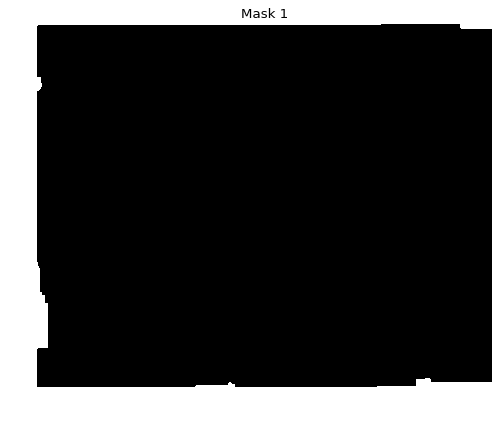

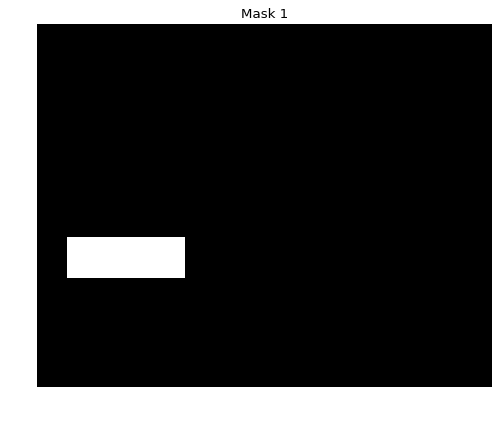

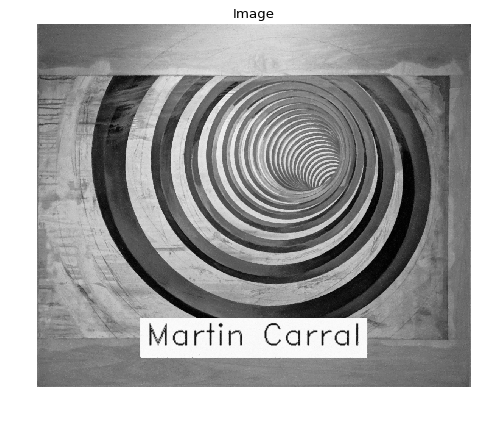

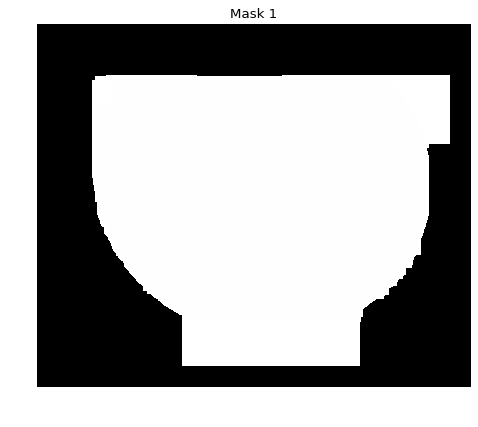

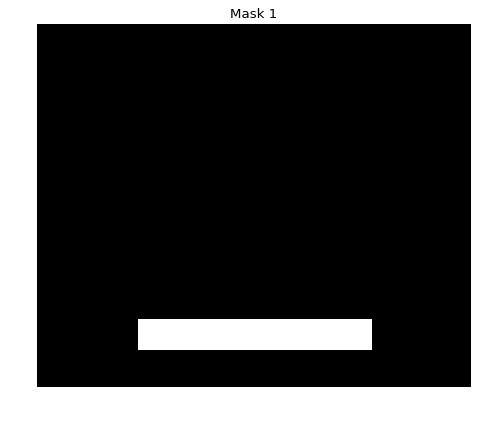

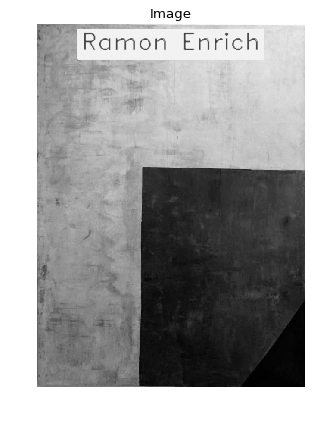

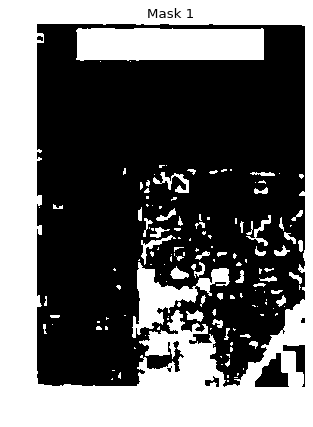

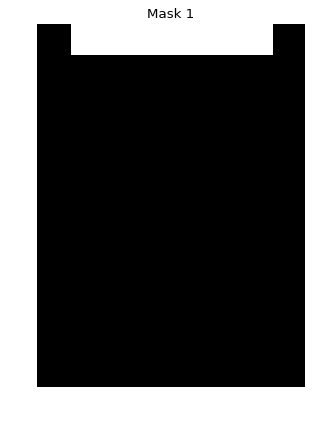

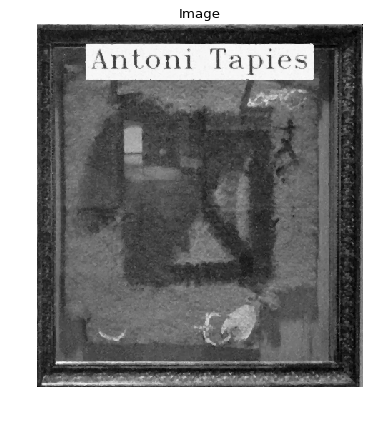

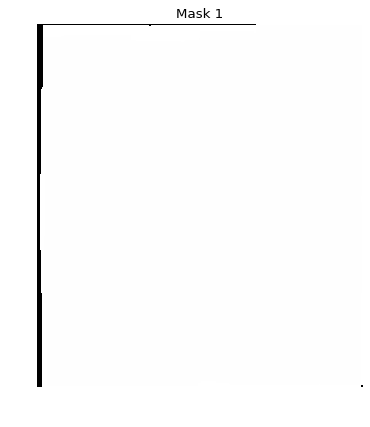

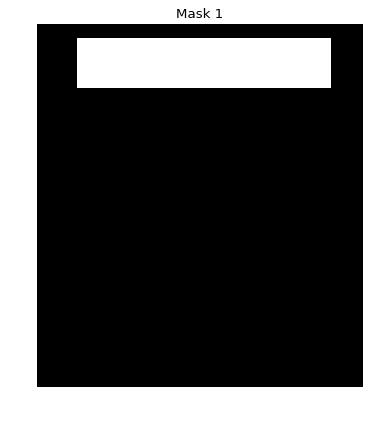

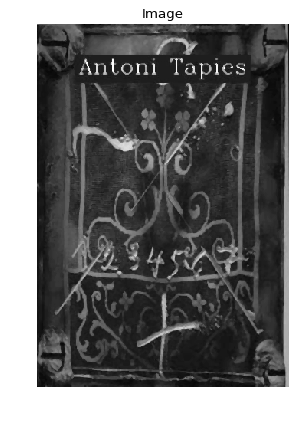

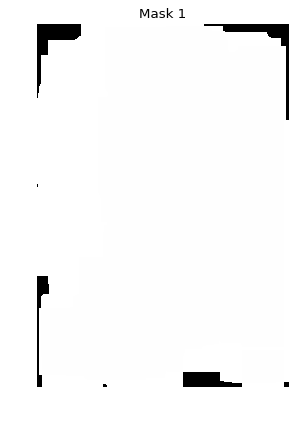

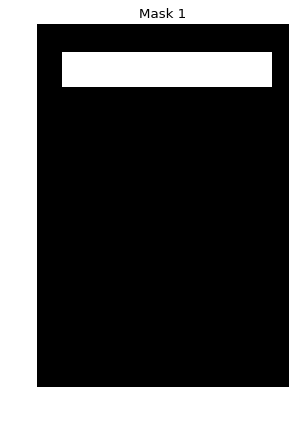

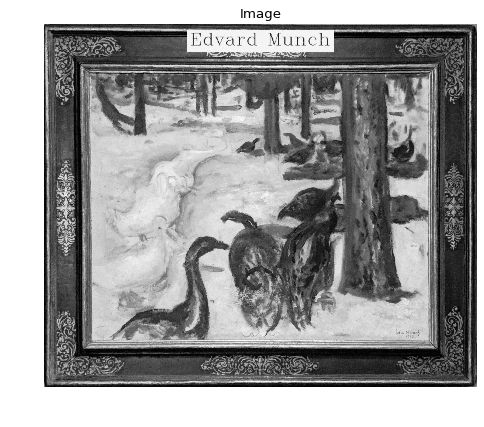

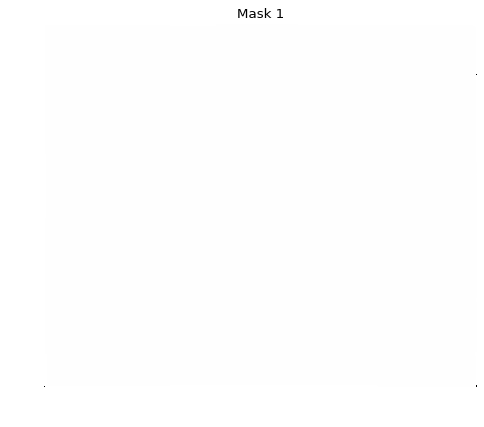

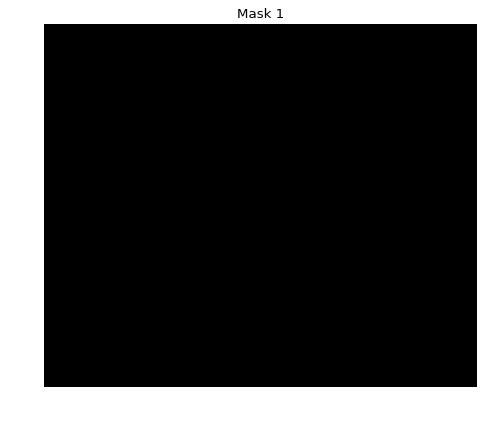

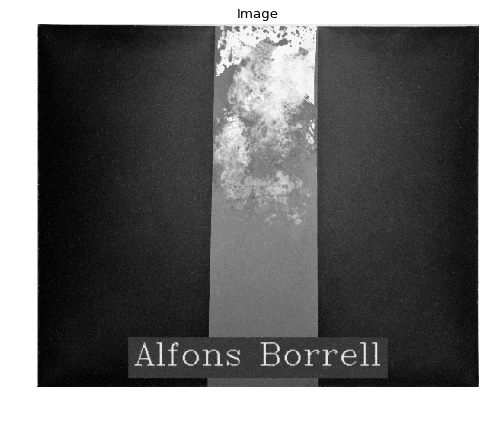

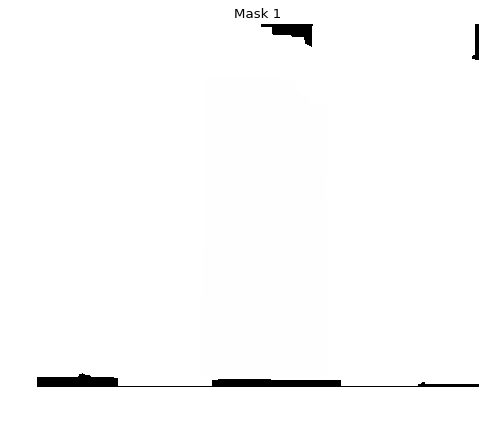

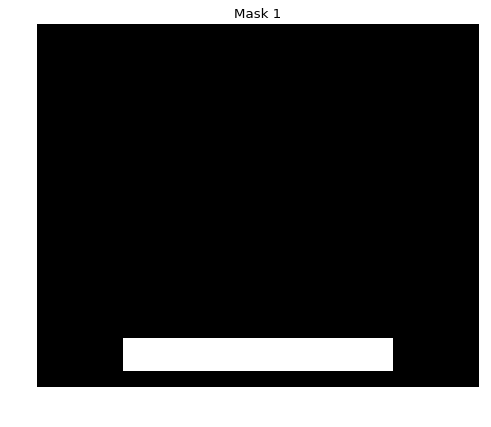

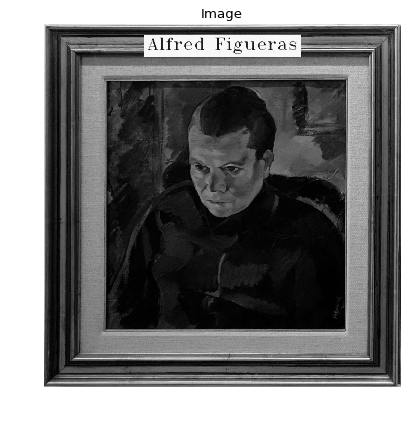

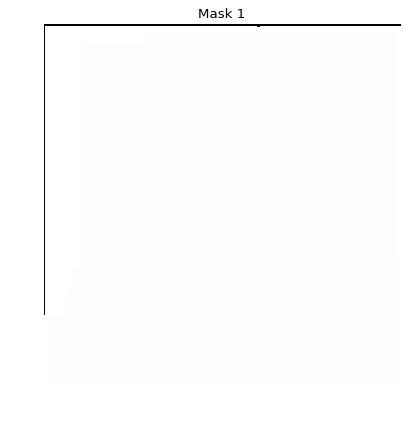

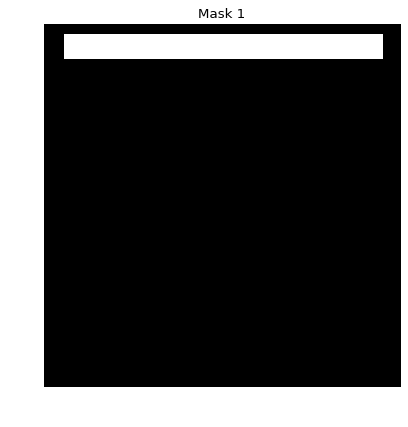

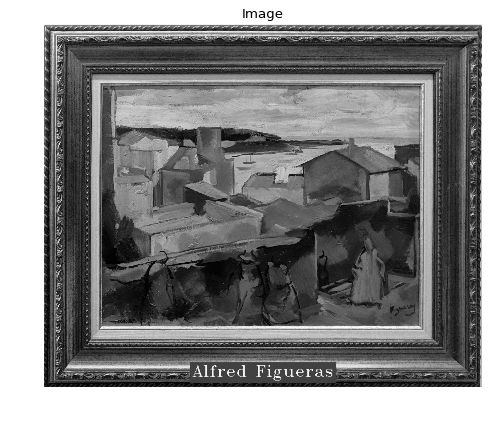

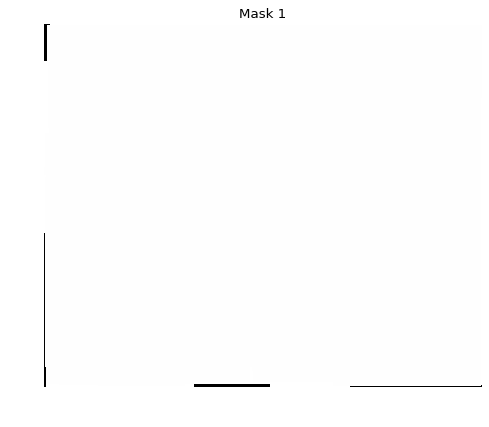

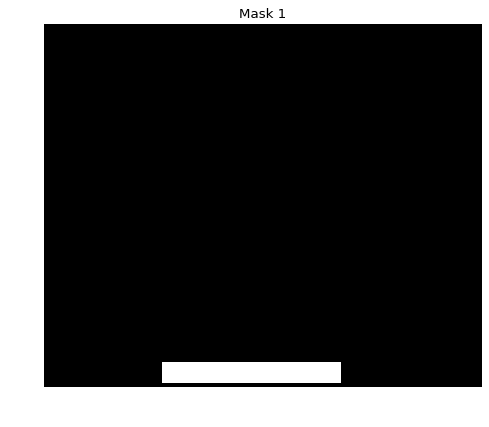

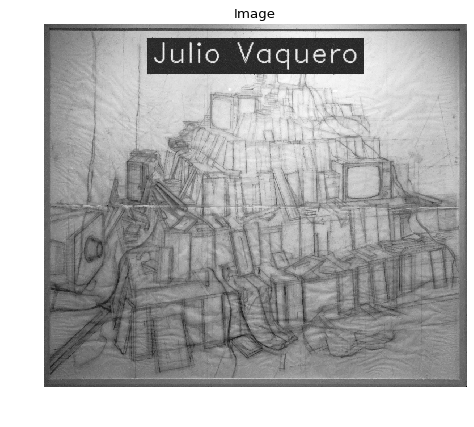

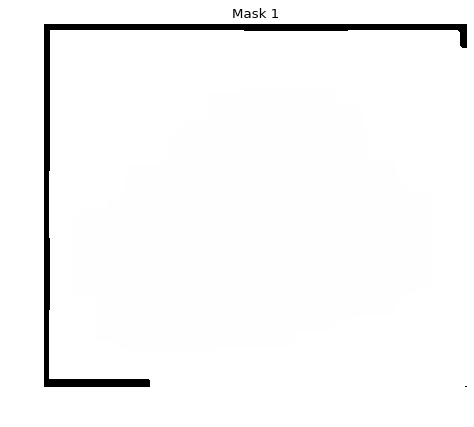

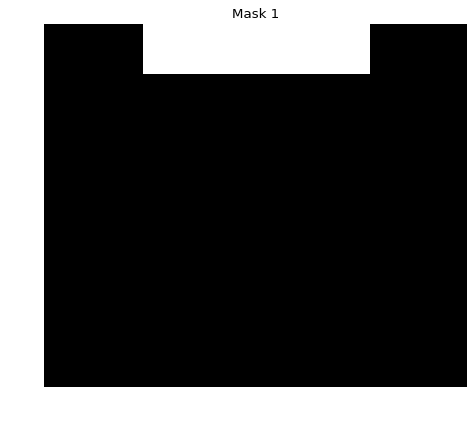

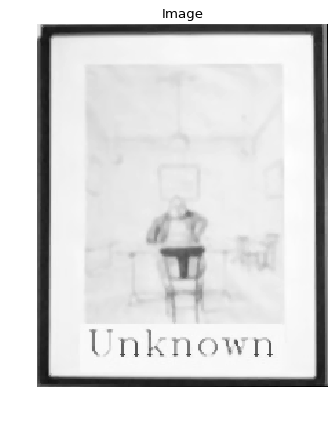

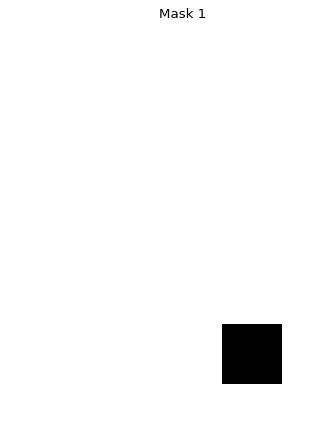

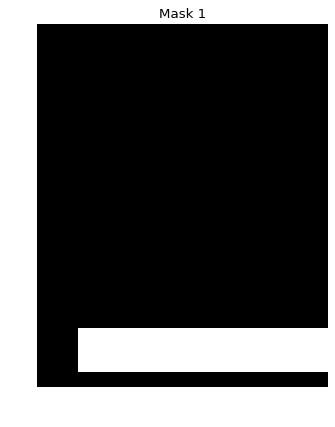

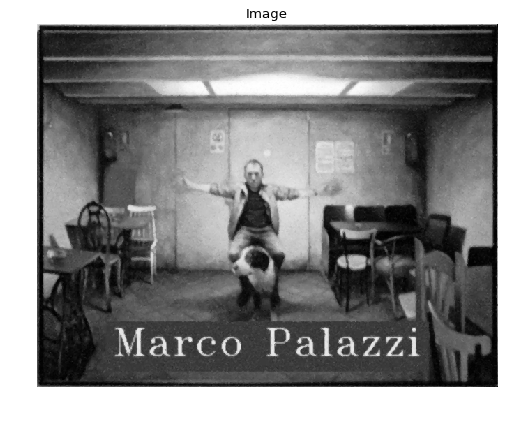

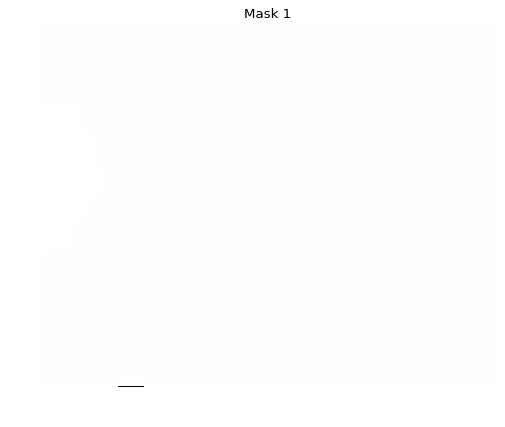

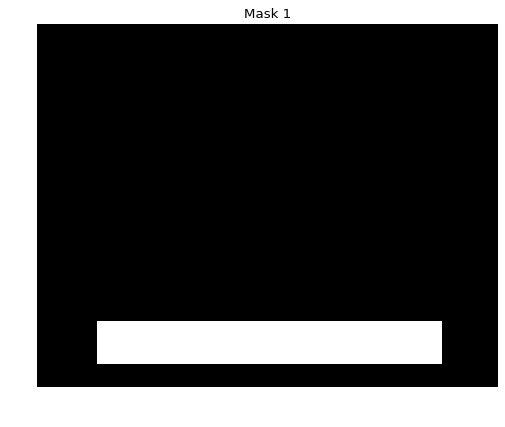

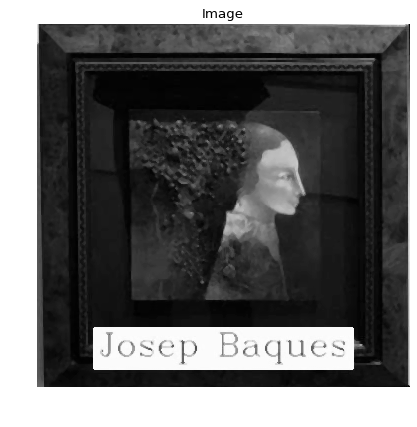

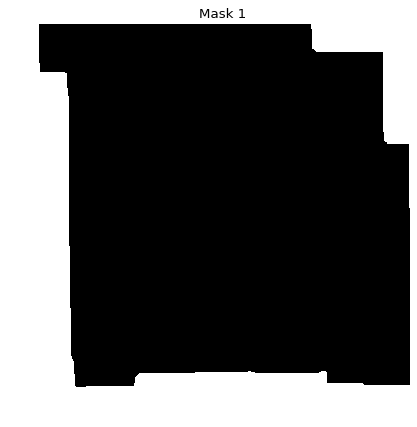

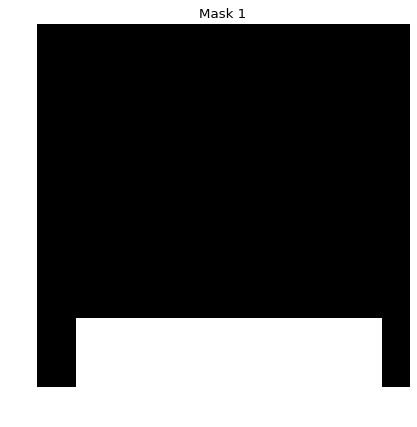

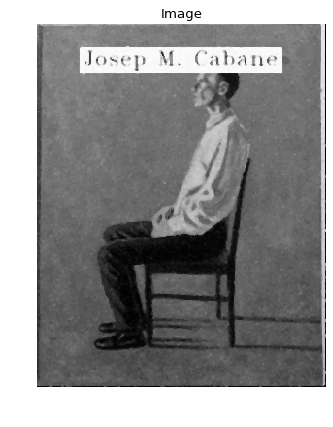

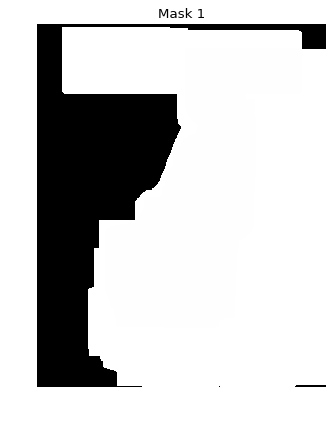

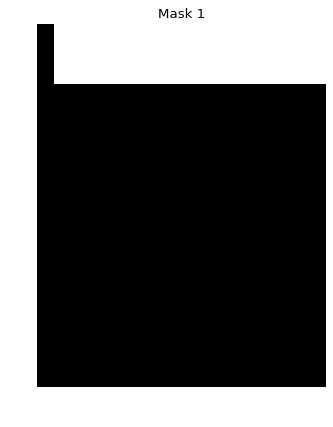

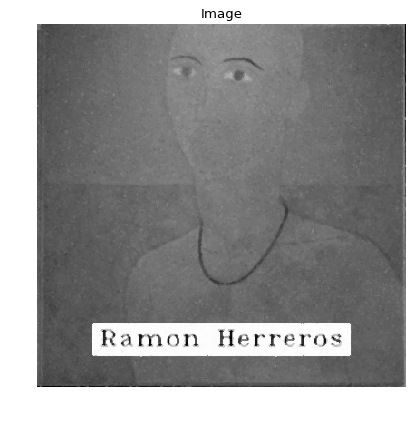

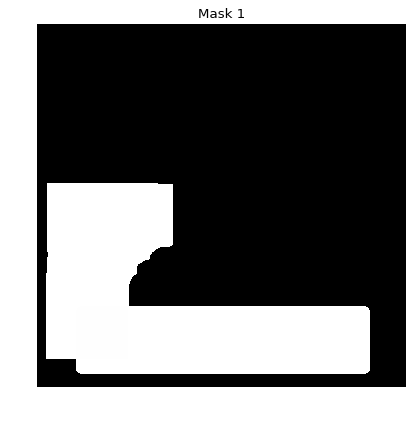

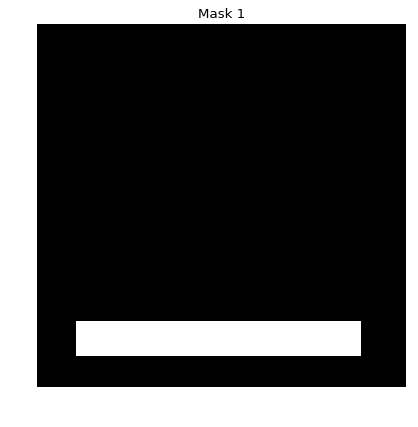

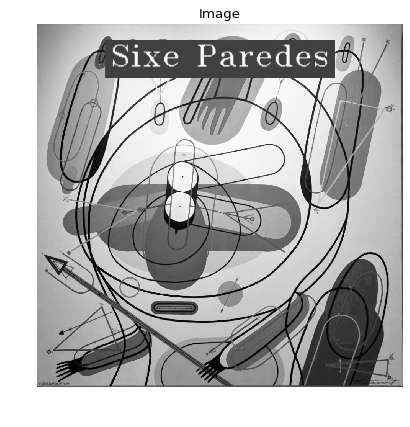

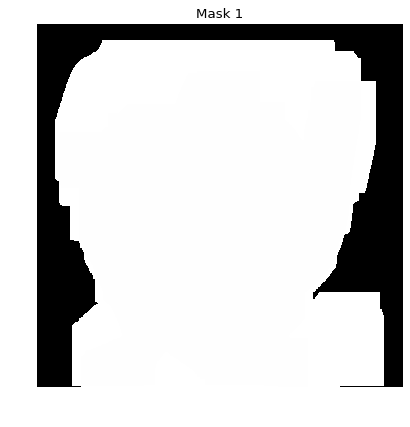

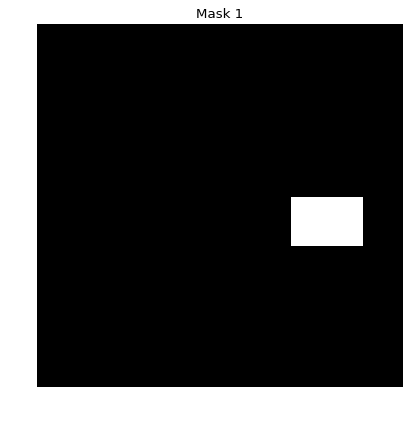

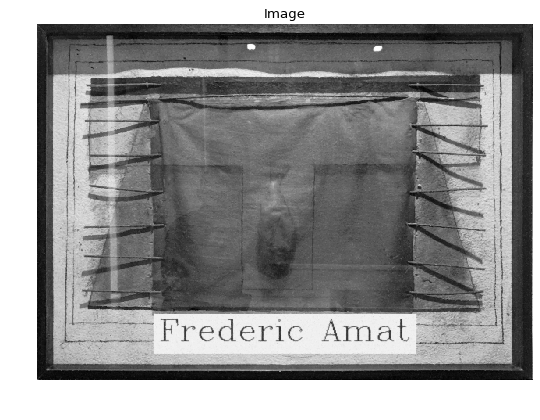

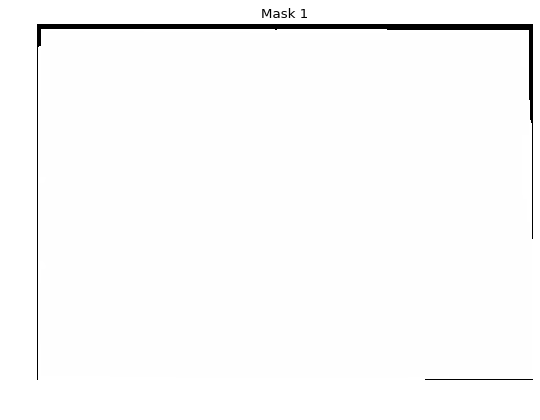

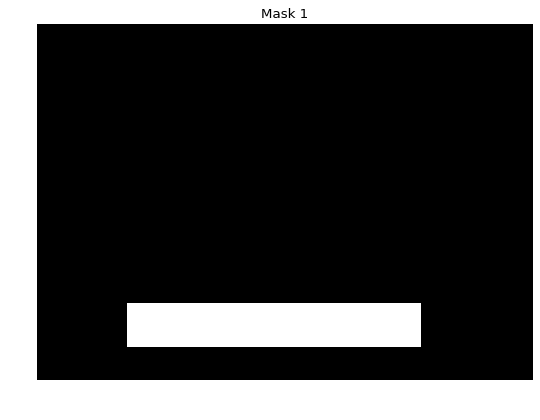

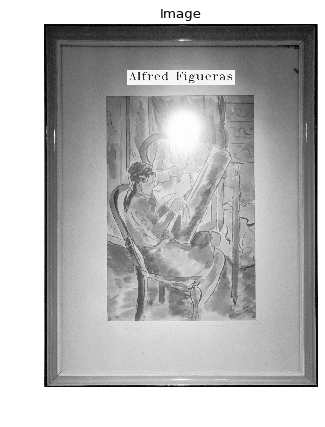

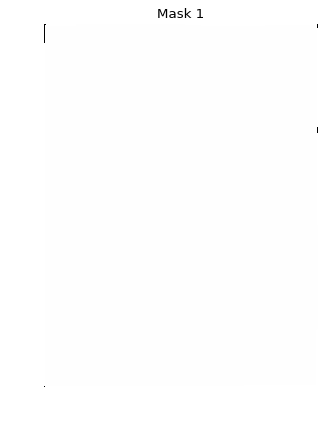

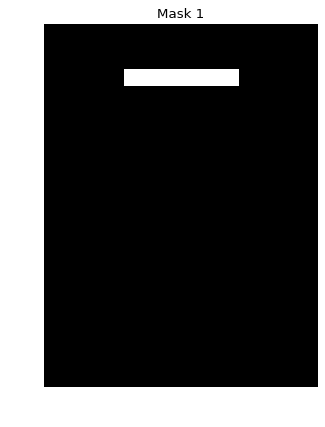

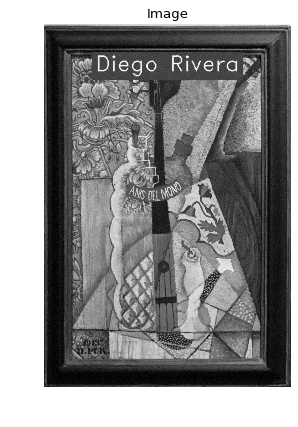

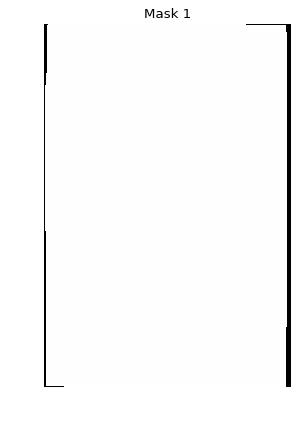

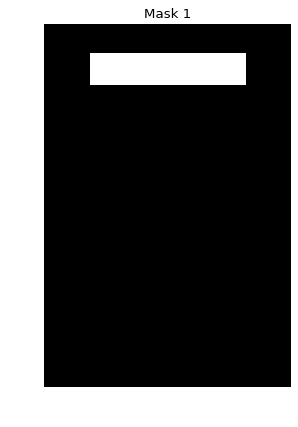

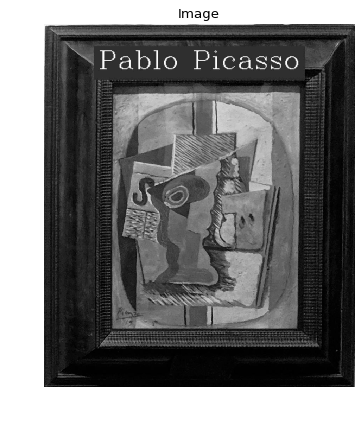

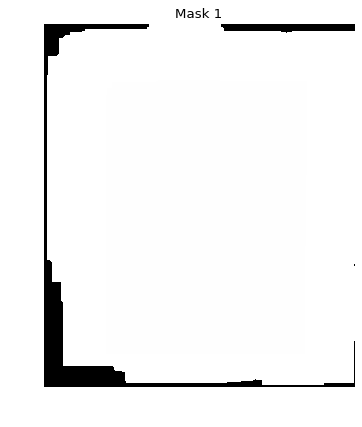

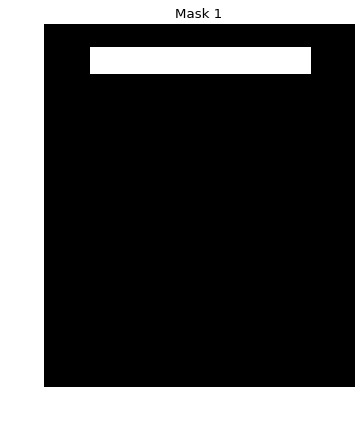

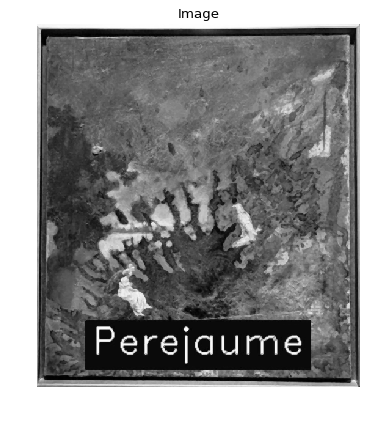

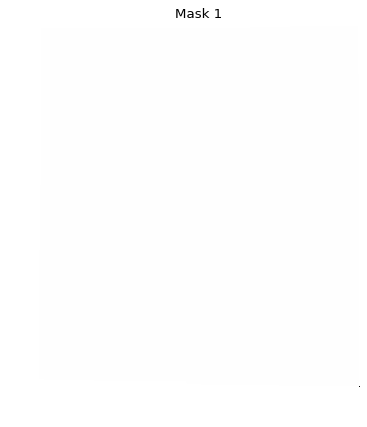

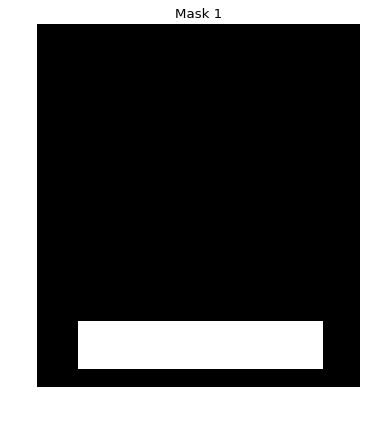

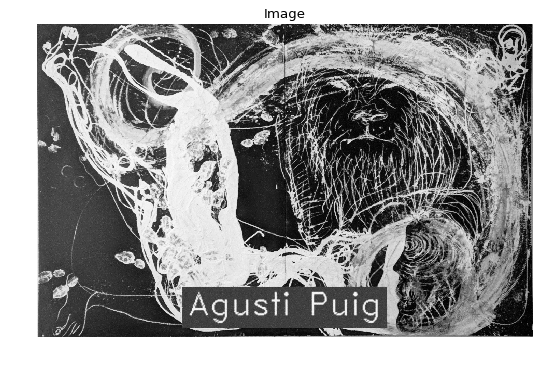

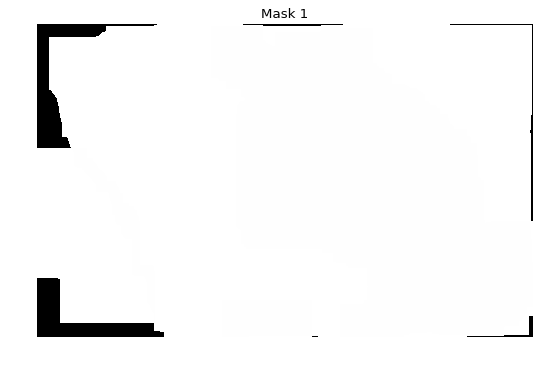

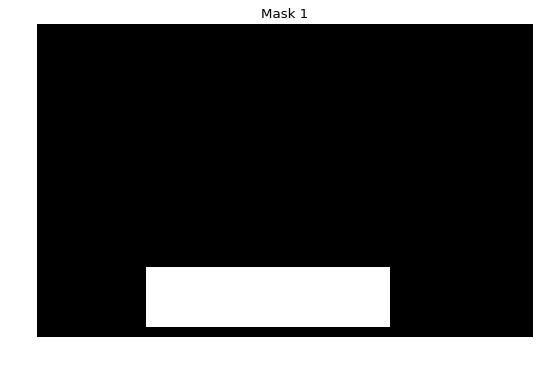

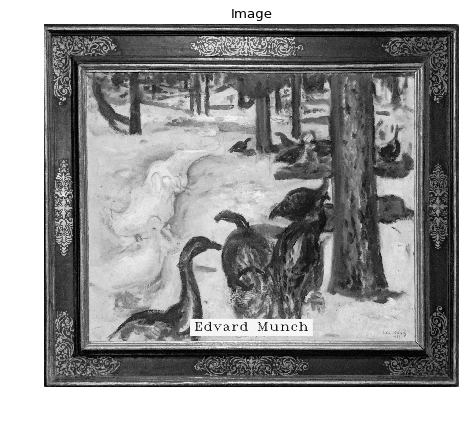

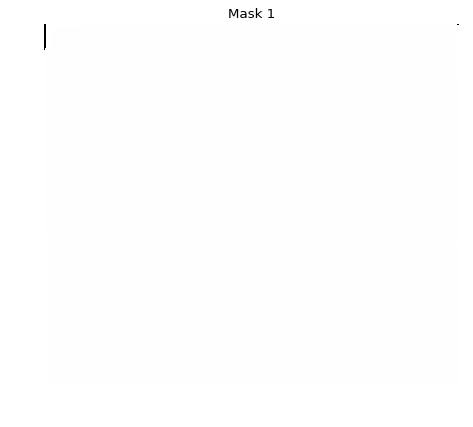

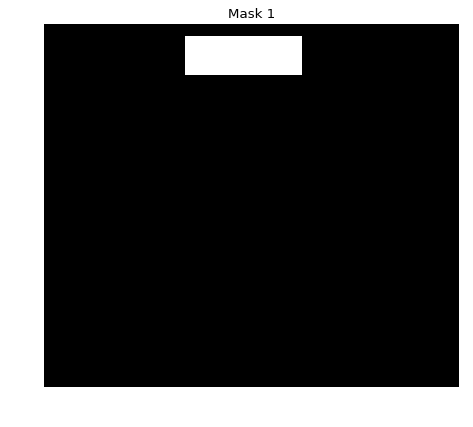

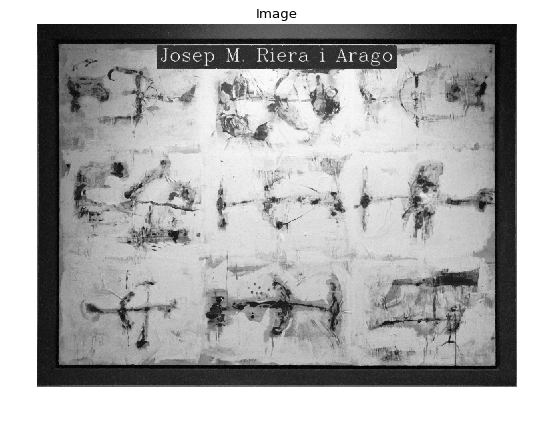

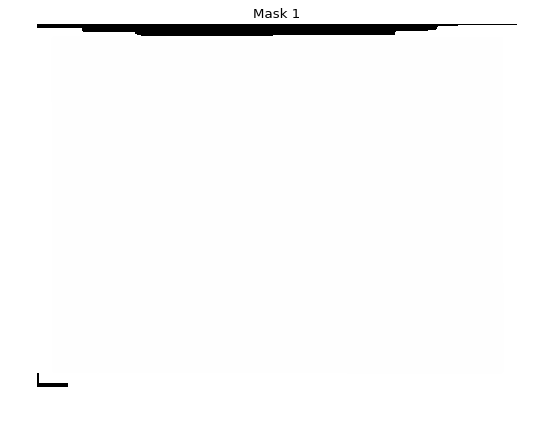

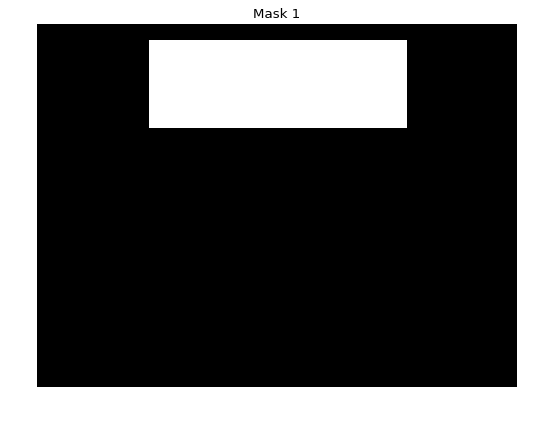

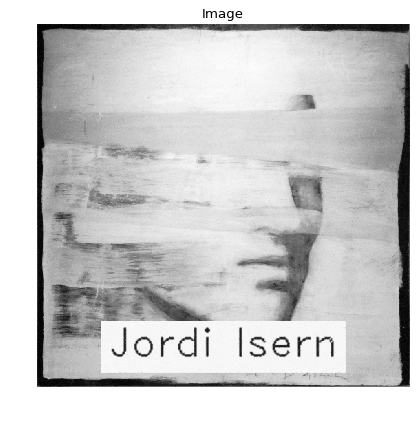

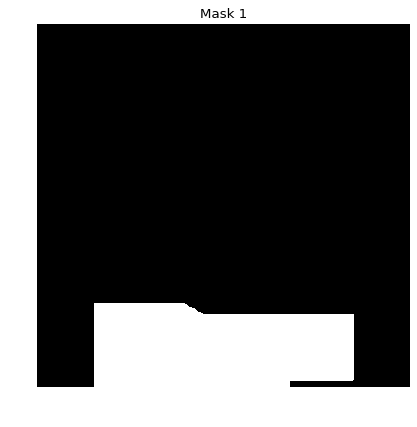

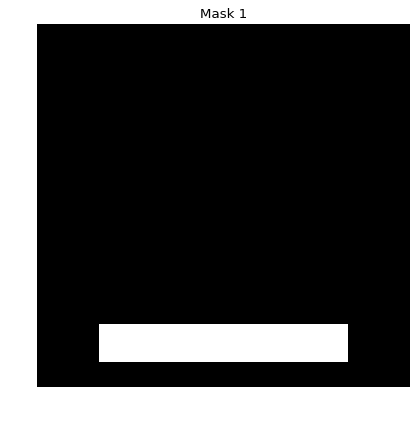

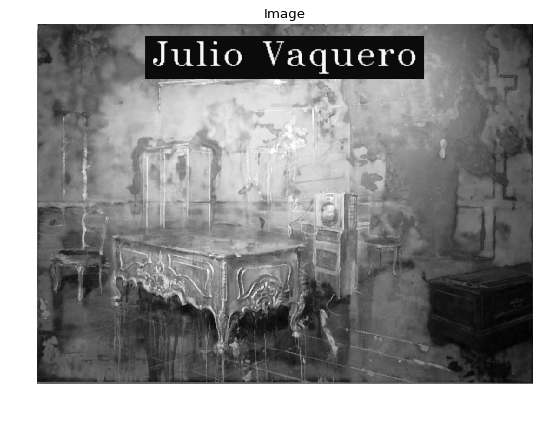

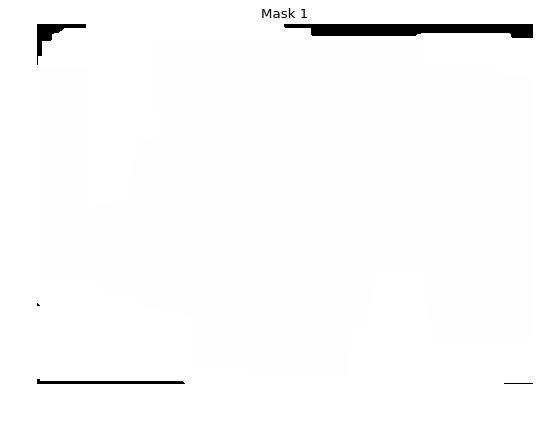

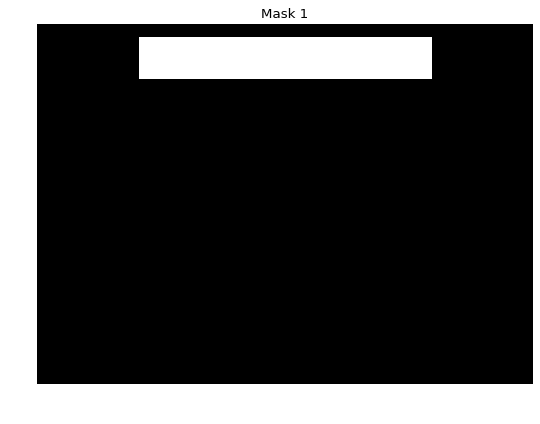

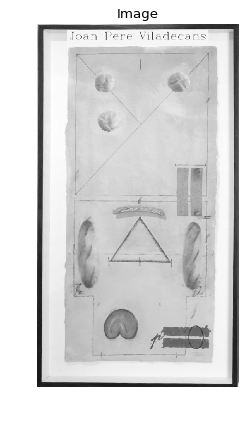

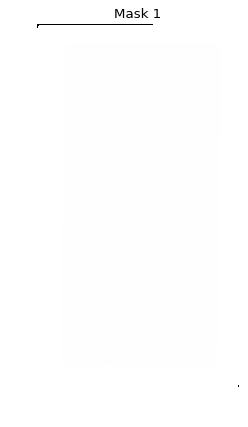

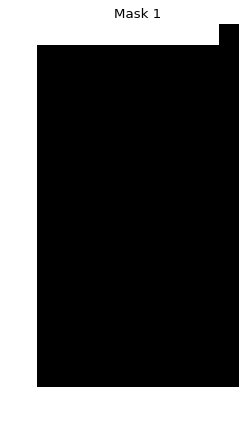

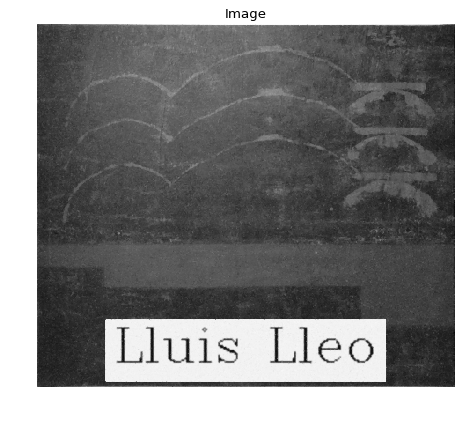

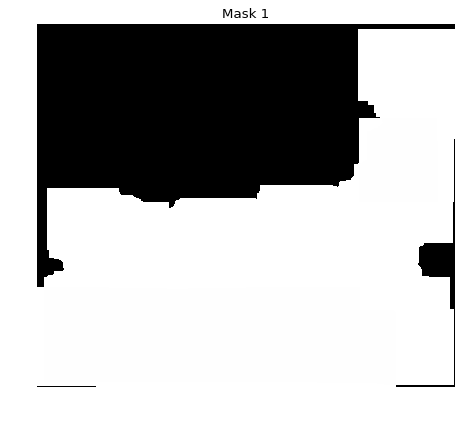

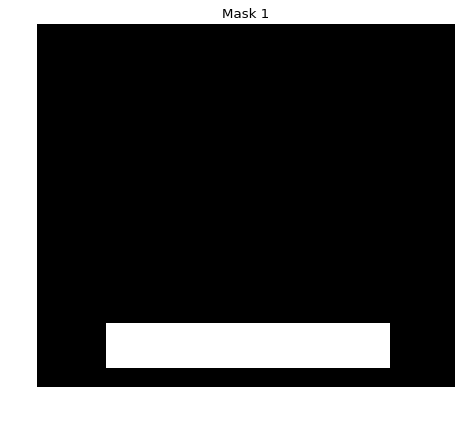

In [43]:
q = 0
QUERY_SET = 'qsd1_w3'
qs_l = '../qs/' + QUERY_SET + '/*.jpg'

for f in sorted(glob.glob(qs_l)):
    # Read image 
    name = os.path.splitext(os.path.split(f)[1])[0]
    im = cv.imread(f, cv.IMREAD_COLOR)
    im = cv.medianBlur(im, 3)
    im_gray = cv.cvtColor(im,cv.COLOR_BGR2GRAY)
    im = cv.cvtColor(im, COLORSPACE)
     
     # Compute background and text masks
    bg_mask,_ = compute_mask(im, "prova" + name, 'qsd1w4')
    text_mask = find_text(im_gray, bg_mask, "provatext" + name)
    # Check whether the image contains two paintings
    length = np.shape(bg_mask)[0]
    
    showImagesHorizontally([im_gray], ["Image"])
    showImagesHorizontally(bg_mask, ["Mask 1", "Mask 2"])
    showImagesHorizontally(text_mask,["Mask 1", "Mask 2"])
    
    if length > 2:
        length = 1
        bg_mask = [bg_mask]
        text_mask = [text_mask]

    pre_list = []
    for m in range(length):
        # Compute SIFT keypoints and descriptors
        kp, des_q = compute_SIFT_kp_and_des(im_gray, None, text_mask[m], sift, size)

        matches_final = np.zeros(279)
        h = 0

        for f in sorted(glob.glob('../database/*.jpg')):

            matches = flann.knnMatch(descriptors_db[h], des_q, k=2)

            # Need to draw only good matches, so create a mask
            matchesMask = [[0,0] for l in range(len(matches))]

            # ratio test as per Lowe's paper
            matches_good = 0

            for k,(m,n) in enumerate(matches):
                if m.distance < 0.5*n.distance:
                    matchesMask[k]=[1,0]
                    matches_good += 1

            # Number of "true" matches
            matches_final[h] = matches_good
            h+=1

        #pre_list.append([np.argmax(matches_final)])
        # Get K paintings from the database with more matches
        topK_matches = (-matches_final).argsort()[:K]
        pre_list.append(topK_matches.tolist())

        print("Query: " + str(q))
        print("Most similar image: " + str(np.argmax(matches_final)))
        print("Number of matches: " + str(np.amax(matches_final)))
    
    final_ranking.append(pre_list)
    q+=1

print(final_ranking)
gt = pickle.load(open('../qs/' + QUERY_SET + '/gt_corresps.pkl','rb'))
mapk_ = np.mean([ml_metrics.mapk([a],p,K) for a,p in zip(gt, final_ranking)])
print('MAP@K = '+ str(mapk_))

TypeError: Invalid dimensions for image data

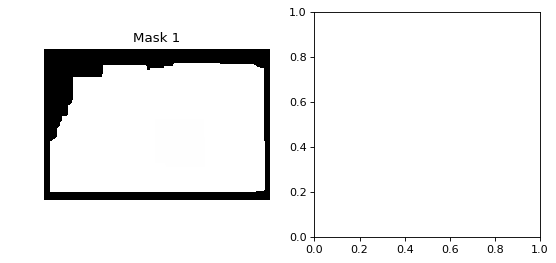

In [20]:
showImagesHorizontally(bg_mask,["Mask 1", "Mask 2"])
showImagesHorizontally(text_mask,["Mask 1", "Mask 2"])

In [ ]:
def show_img_gray(img):
    plt.imshow(img, cmap = plt.cm.gray)
    plt.show()